# Big Data Project: Flight Delay Prediction Using Spark Streaming & Kafka

## (1) Data Loading

Flight Dataset: https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023?select=flights_sample_3m.csv

### Flight Info
* FL_DATE - Flight Date (yyyymmdd)
* AIRLINE_CODE - Reporting Airline / Unique Carrier Code. When the same code has been used by multiple carriers, a numeric suffix is used for earlier users, for example, PA, PA(1), PA(2). Use this field for analysis across a range of years.
* DOT_CODE - An identification number assigned by US DOT to identify a unique airline (carrier). A unique airline (carrier) is defined as one holding and reporting under the same DOT certificate regardless of its Code, Name, or holding company/corporation.</td>
* FL_NUMBER - Flight Number

### Locations
* ORIGIN - Origin Airport
* ORIGIN_CITY - Origin Airport, City Name
* DEST - Destination Airport
* DEST_CITY - Destination Airport, City Name

### Departure
* CRS_DEP_TIME - Computer Reservation System Departure Time (local time: hhmm)
* DEP_TIME - Actual Departure Time (local time: hhmm)
* DEP_DELAY - Difference in minutes between scheduled and actual departure time. Early departures show negative numbers.

### Takeoff/Landing
* TAXI_OUT - Taxi Out Time, in Minutes
* WHEELS_OFF - Wheels Off Time (local time: hhmm)
* WHEELS_ON - Wheels On Time (local time: hhmm)
* TAXI_IN - Taxi In Time, in Minutes

### Arrival
* CRS_ARR_TIME - Computer Reservation System Arrival Time (local time: hhmm)
* ARR_TIME - Actual Arrival Time (local time: hhmm)
* ARR_DELAY - Difference in minutes between scheduled and actual arrival time. Early arrivals show negative numbers.

### Cancellation/Diversion
* CANCELLED - Cancelled Flight Indicator (1=Yes)
* CANCELLATION_CODE - Specifies The Reason For Cancellation
* DIVERTED - Diverted Flight Indicator (1=Yes)

### Flight
* CRS_ELAPSED_TIME - Computer Reservation System Elapsed Time of Flight, in Minutes
* ELAPSED_TIME - Elapsed Time of Flight, in Minutes
* AIR_TIME - Flight Time, in Minutes
* DISTANCE - Distance between airports (miles)

### Delay
* DELAY_DUE_CARRIER - Carrier Delay, in Minutes
* DELAY_DUE_WEATHER - Weather Delay, in Minutes
* DELAY_DUE_NAS - National Air System Delay, in Minutes
* DELAY_DUE_SECURITY - Security Delay, in Minutes
* DELAY_DUE_LATE_AIRCRAFT - Late Aircraft Delay, in Minutes

[1.1] Output: Dataframe Schema

In [1]:
# Setup Spark path
import findspark
findspark.init()

# Initialize Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("FlightDelayPrediction") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# Load and parse the data file, converting it to a DataFrame.
df = spark.read.csv("flight_data.csv", header=True, inferSchema=True)

# Testing Purposes: Show 1st 5 rows of dataframe
# df.show(5)

# Show schema of dataframe
df.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/16 20:34:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/16 20:35:01 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
[Stage 1:==============>                                            (1 + 3) / 4]

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

## (2) Data Cleaning/Transformation

[2.1] Output: Showing Null Counts before Cleaning

In [2]:
# Import pyspark SQL functions & ML features
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler

# Dropping columns we don't need
columns_to_drop = ['CANCELLATION_CODE', 'AIRLINE_DOT', 'DOT_CODE', 'FL_NUMBER']
df = df.drop(*columns_to_drop)

# Create a DataFrame with column names and their respective null counts
null_counts = [(col, df.filter(df[col].isNull()).count()) for col in df.columns]
null_df = spark.createDataFrame(null_counts, ["Column", "Null_Count"])

# Show the result
null_df.show(30)

+--------------------+----------+
|              Column|Null_Count|
+--------------------+----------+
|             FL_DATE|         0|
|             AIRLINE|         0|
|        AIRLINE_CODE|         0|
|              ORIGIN|         0|
|         ORIGIN_CITY|         0|
|                DEST|         1|
|           DEST_CITY|         1|
|        CRS_DEP_TIME|         1|
|            DEP_TIME|      6993|
|           DEP_DELAY|      6996|
|            TAXI_OUT|      7087|
|          WHEELS_OFF|      7087|
|           WHEELS_ON|      7186|
|             TAXI_IN|      7186|
|        CRS_ARR_TIME|         1|
|            ARR_TIME|      7186|
|           ARR_DELAY|      7699|
|           CANCELLED|         1|
|            DIVERTED|         1|
|    CRS_ELAPSED_TIME|         3|
|        ELAPSED_TIME|      7699|
|            AIR_TIME|      7699|
|            DISTANCE|         1|
|   DELAY_DUE_CARRIER|    218893|
|   DELAY_DUE_WEATHER|    218893|
|       DELAY_DUE_NAS|    218893|
|  DELAY_DUE_S

In [3]:
# Assuming that if ARR_DELAY or DEP_DELAY are null then either:
# 1) Missing data entries
# 2) Corrupt data entries

# Drop null values
df = df.dropna(subset=["ARR_DELAY", "DEP_DELAY"])

# Filling null values with 0 for these specific columns since there is no delay 
# due to these issues
df = df.fillna({
    'DELAY_DUE_CARRIER': 0, 
    'DELAY_DUE_WEATHER': 0, 
    'DELAY_DUE_NAS': 0, 
    'DELAY_DUE_SECURITY': 0, 
    'DELAY_DUE_LATE_AIRCRAFT': 0
})

In [4]:
# Editing format of the date for easier use
df = df.withColumn("FL_DATE", F.to_date(F.col("FL_DATE"), "yyyy-MM-dd"))

# extracting time-based features from scheduled departure time (CRS_DEP_TIME) column
df = df.withColumn("DEP_HOUR", (F.col("CRS_DEP_TIME") / 100).cast("integer"))
df = df.withColumn("DEP_DAY_OF_WEEK", F.dayofweek(F.col("FL_DATE")))
df = df.withColumn("DEP_MONTH", F.month(F.col("FL_DATE")))

# weekend flights most likely have higher likelihood of being delayed so we'll flag these
df = df.withColumn("IS_WEEKEND", F.when(F.col("DEP_DAY_OF_WEEK").isin([1, 7]), 1).otherwise(0))

[2.2] Output: Basic Numerical Data Summary

In [5]:
# import pandas
import pandas as pd

# Create a list of numeric columns in dataframe
# Not using time based: CRS_DEP_TIME/DEP_TIME, CRS_ARR_TIME/ARR_TIME, CRS_ELAPSED_TIME/ELAPSED_TIME, WHEELS_OFF/WHEELS_ON
# Not using binary based: CANCELLED/DIVERTED
numeric_cols = ["DEP_DELAY", "TAXI_OUT", "TAXI_IN", "ARR_DELAY", "AIR_TIME", "DISTANCE",
                "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS", "DELAY_DUE_SECURITY", "DELAY_DUE_LATE_AIRCRAFT",
                "DEP_HOUR", "DEP_DAY_OF_WEEK", "DEP_MONTH", "IS_WEEKEND"]

# Testing Purposes: Show list of numeric columns of dataframe
# print(numeric_cols)

# Get the basic statistics of the DataFrame for the numeric columns
df_stats = df.select([F.round(F.col(c), 2).alias(c) for c in numeric_cols]).describe()

# Convert the result to a Pandas DataFrame
df_stats_pd = df_stats.toPandas()

# Round the numeric values (except for the 'summary' row)
df_stats_pd.iloc[1:, 1:] = df_stats_pd.iloc[1:, 1:].apply(pd.to_numeric, errors='coerce').round(2)

# Set the 'summary' features as the index
df_stats_pd.set_index('summary', inplace=True)

print(df_stats_pd)

25/04/16 20:35:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 90:>                                                         (0 + 1) / 1]

        DEP_DELAY TAXI_OUT TAXI_IN ARR_DELAY AIR_TIME DISTANCE  \
summary                                                          
count      258676   258676  258676    258676   258676   258676   
mean        10.14    16.64    7.67      4.34   112.18   809.64   
stddev      49.27     9.19    6.21      51.4    69.53   587.51   
min         -68.0      1.0     1.0     -81.0      8.0     30.0   
max        1732.0    172.0   222.0    1741.0    661.0   5095.0   

        DELAY_DUE_CARRIER DELAY_DUE_WEATHER DELAY_DUE_NAS DELAY_DUE_SECURITY  \
summary                                                                        
count              258676            258676        258676             258676   
mean                 4.57              0.72          2.41               0.03   
stddev              31.76             14.67         15.21               1.41   
min                   0.0               0.0           0.0                0.0   
max                1732.0            1398.0        1468.0

In [6]:
# severe delay for flights delayed over one hour
df = df.withColumn("SEVERE_DELAY", F.when(F.col("ARR_DELAY") >= 60, 1).otherwise(0))

## (3) Visualization

## Arrival Delays
- 1st Graph: Log Frequency Distribution
- 2nd Graph: Average by airline
- 3rd Graph: Average by airport (Origin City)
- 4th Graph: Average by airport (Destination City)
- 5th Graph: Average by day of week
- 6th Graph: Average by month of year
- 7th Graph: Average by hour of day


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pd = df.select("ARR_DELAY", "AIRLINE", "ORIGIN", "DEST", "DEP_HOUR", "DEP_DAY_OF_WEEK", "DEP_MONTH",
                     "DELAY_DUE_CARRIER", "DELAY_DUE_WEATHER", "DELAY_DUE_NAS", "DELAY_DUE_SECURITY", 
                  "DELAY_DUE_LATE_AIRCRAFT", "SEVERE_DELAY").toPandas()

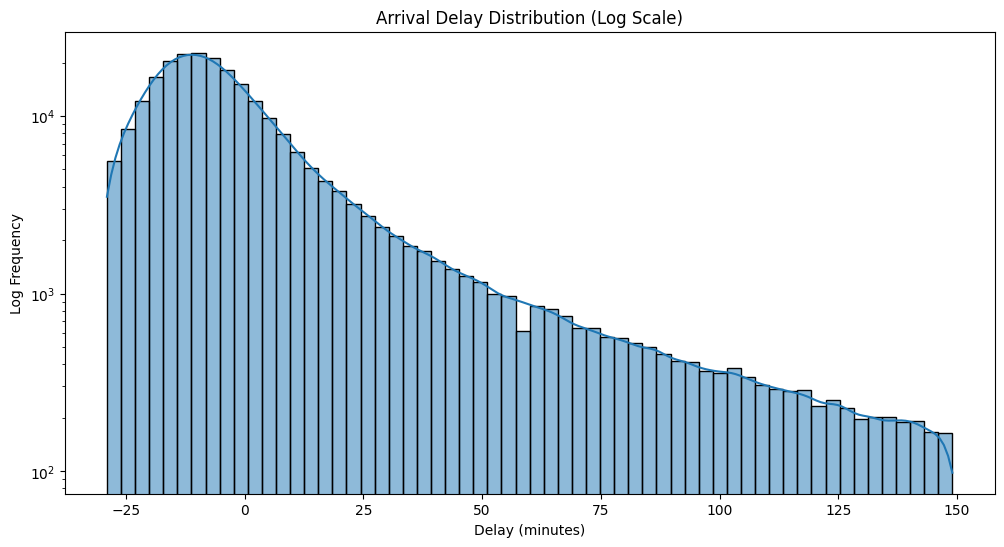

In [59]:
# Arrival Delay Distribution
pd_df_filtered = df_pd[(df_pd["ARR_DELAY"] > -30) & (df_pd["ARR_DELAY"] < 150)]

plt.figure(figsize=(12, 6))
sns.histplot(pd_df_filtered["ARR_DELAY"].dropna(), bins=60, kde=True)
plt.yscale("log")
plt.title("Arrival Delay Distribution (Log Scale)")
plt.xlabel("Delay (minutes)")
plt.ylabel("Log Frequency")
plt.show()

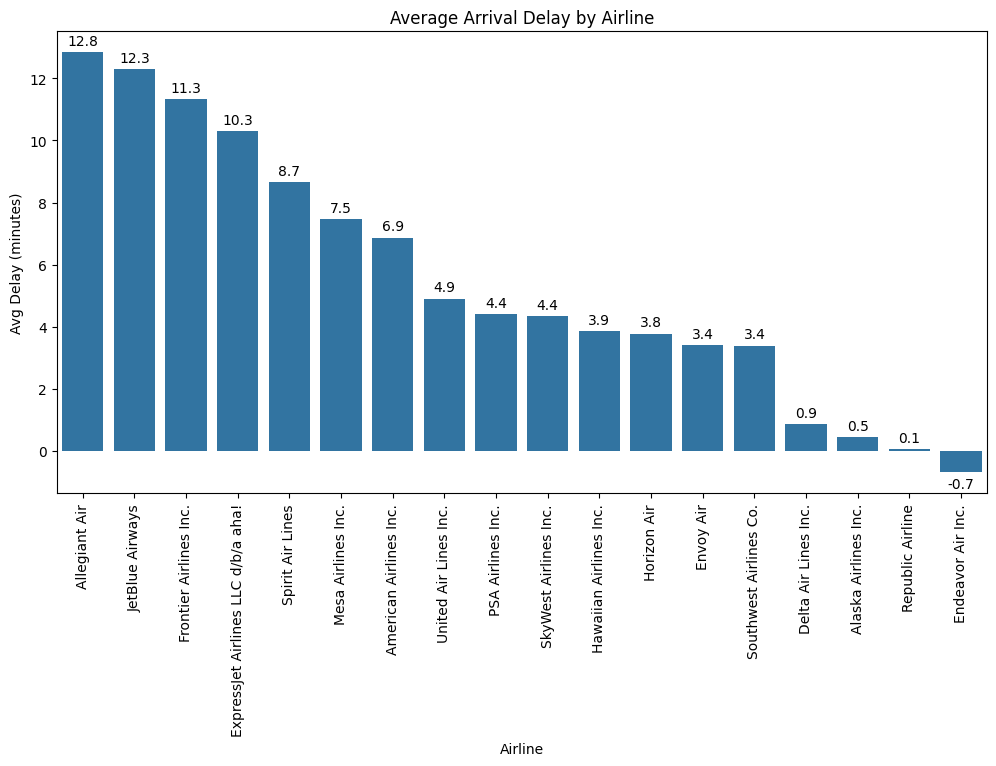

In [60]:
# Average Arrival Delay by Airline
airline_delays = df_pd.groupby("AIRLINE")["ARR_DELAY"].mean().reset_index().sort_values("ARR_DELAY", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="AIRLINE", y="ARR_DELAY", data=airline_delays)
plt.xticks(rotation=90)
plt.title("Average Arrival Delay by Airline")
plt.xlabel("Airline")
plt.ylabel("Avg Delay (minutes)")
plt.gca().bar_label(plt.gca().containers[0], fmt="%.1f", padding=3)
plt.show()

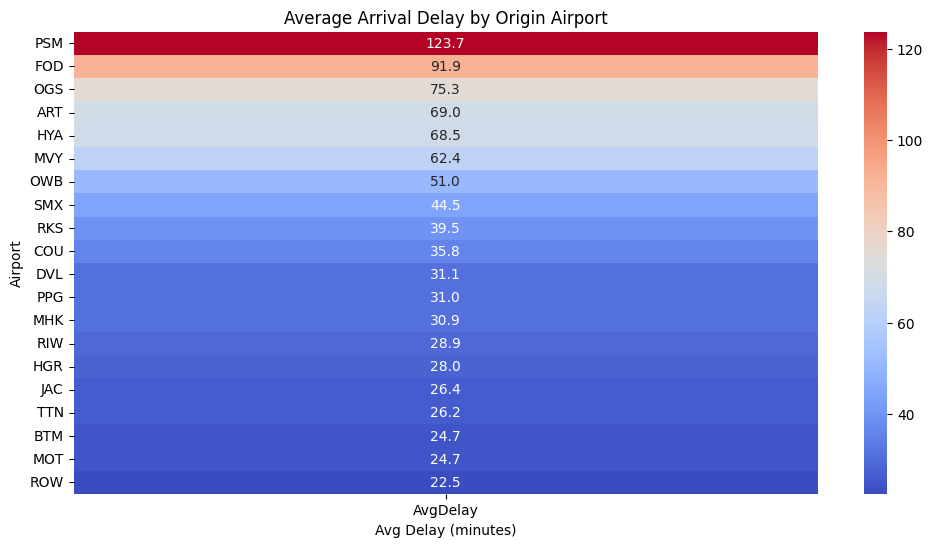

In [61]:
# Average Arrival Delay by Origin Airport
airport_delays = df.groupBy("ORIGIN").agg(F.avg("ARR_DELAY").alias("AvgDelay")).toPandas()
airport_delays = airport_delays.sort_values("AvgDelay", ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.heatmap(airport_delays.set_index("ORIGIN"), cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Average Arrival Delay by Origin Airport")
plt.xlabel("Avg Delay (minutes)")
plt.ylabel("Airport")
plt.show()

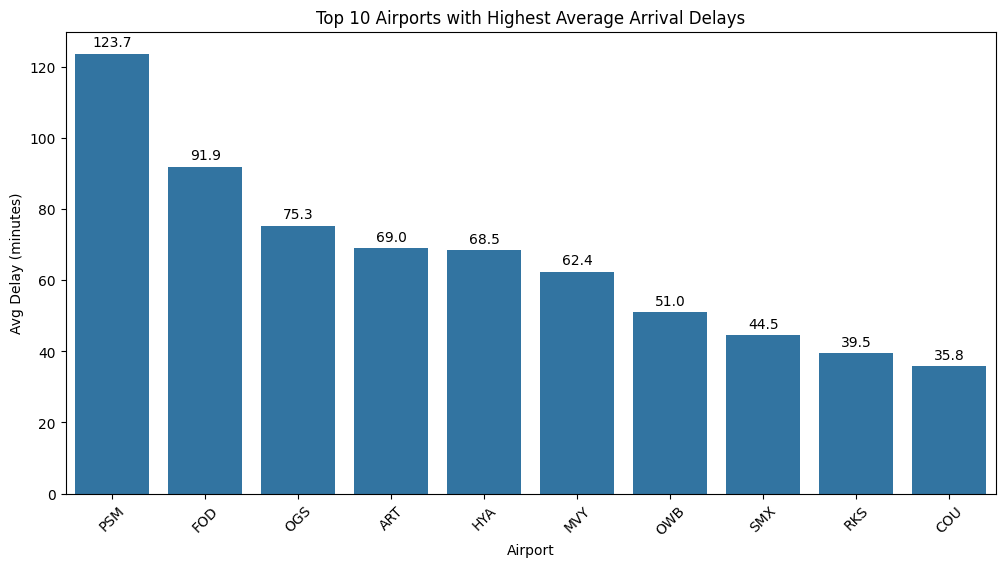

In [62]:
# Top 10 Airports with Highest Delays
airport_delays = df_pd.groupby("ORIGIN")["ARR_DELAY"].mean().reset_index().sort_values("ARR_DELAY", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x="ORIGIN", y="ARR_DELAY", data=airport_delays)
plt.title("Top 10 Airports with Highest Average Arrival Delays")
plt.xlabel("Airport")
plt.ylabel("Avg Delay (minutes)")
plt.xticks(rotation=45)
plt.gca().bar_label(plt.gca().containers[0], fmt="%.1f", padding=3)
plt.show()


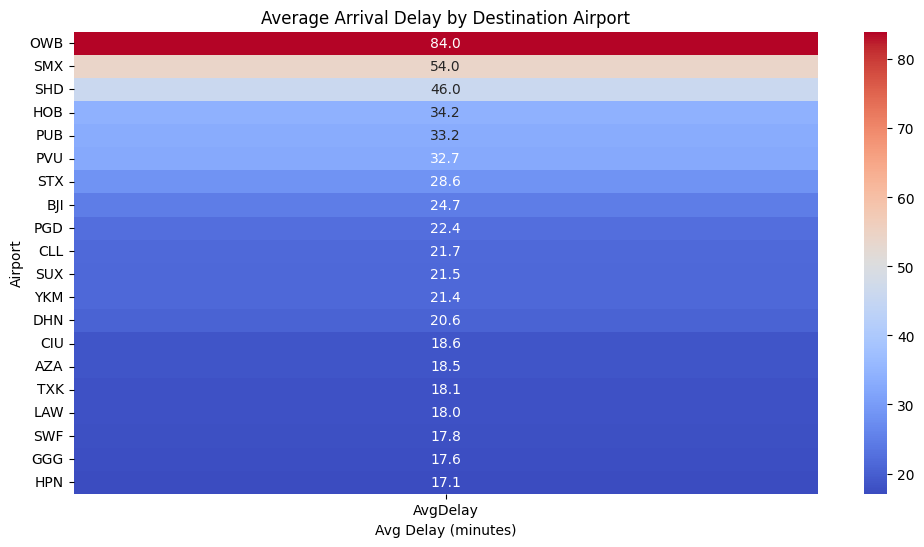

In [63]:
# Average Arrival Delay by Destination Airport
airport_delays = df.groupBy("DEST").agg(F.avg("ARR_DELAY").alias("AvgDelay")).toPandas()
airport_delays = airport_delays.sort_values("AvgDelay", ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.heatmap(airport_delays.set_index("DEST"), cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Average Arrival Delay by Destination Airport")
plt.xlabel("Avg Delay (minutes)")
plt.ylabel("Airport")
plt.show()

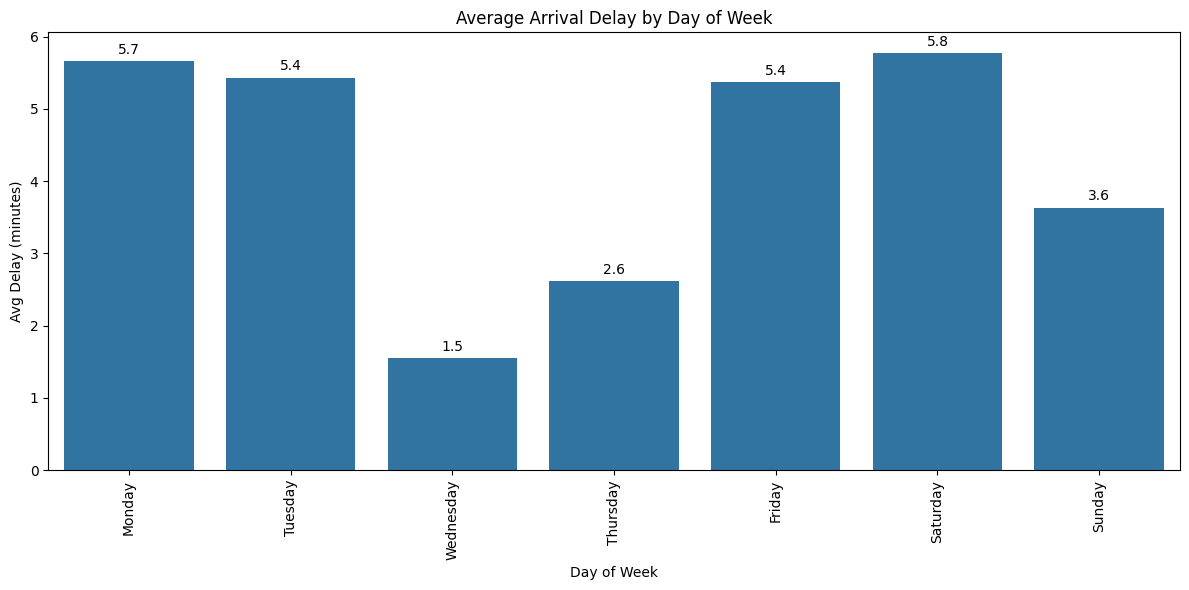

In [64]:
# Average Arrival Delay by Day of Week
day_delays = (
    df_pd
      .groupby("DEP_DAY_OF_WEEK")["ARR_DELAY"]
      .mean()
      .reset_index()
)

# map 1–7 to names and sort
weekday_map = {
    1: "Monday", 2: "Tuesday", 3: "Wednesday",
    4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"
}
day_delays["Weekday"] = day_delays["DEP_DAY_OF_WEEK"].map(weekday_map)
day_delays = day_delays.sort_values("DEP_DAY_OF_WEEK")

plt.figure(figsize=(12, 6))
sns.barplot(x="Weekday", y="ARR_DELAY", data=day_delays)
plt.xticks(rotation=90)
plt.title("Average Arrival Delay by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Avg Delay (minutes)")
plt.gca().bar_label(plt.gca().containers[0], fmt="%.1f", padding=3)
plt.tight_layout()
plt.show()


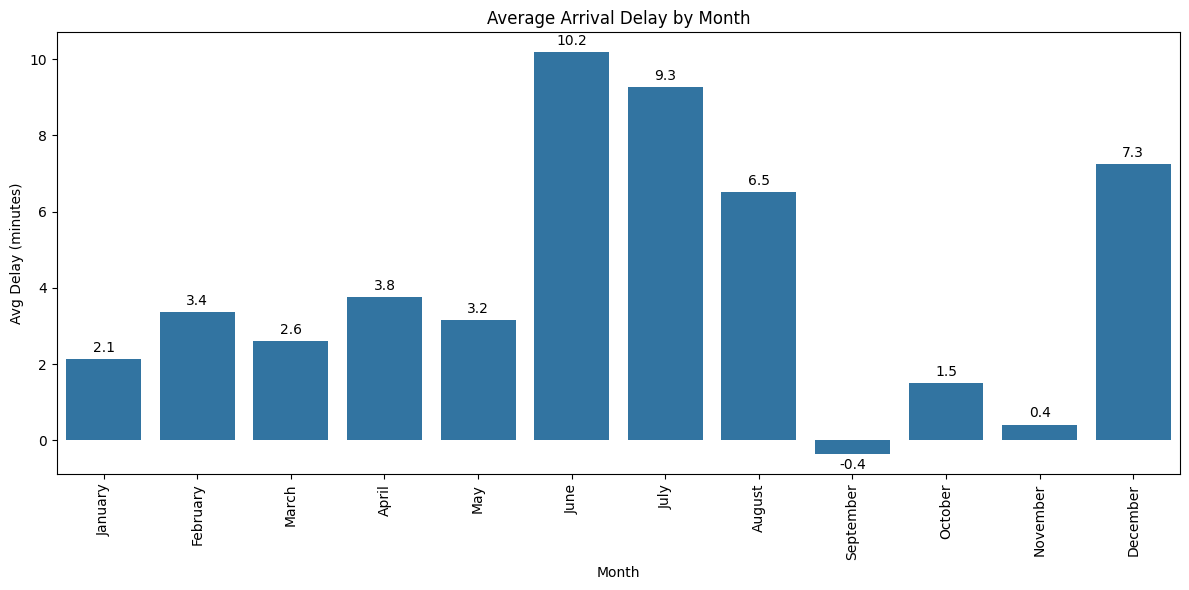

In [65]:
# Average Arrival Delay by Month
month_delays = (
    df_pd
      .groupby("DEP_MONTH")["ARR_DELAY"]
      .mean()
      .reset_index()
)

# map 1–12 to names and sort
month_map = {
    1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 
    7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"
}
month_delays["Month"] = month_delays["DEP_MONTH"].map(month_map)
month_delays = month_delays.sort_values("DEP_MONTH")

plt.figure(figsize=(12, 6))
sns.barplot(x="Month", y="ARR_DELAY", data=month_delays)
plt.xticks(rotation=90)
plt.title("Average Arrival Delay by Month")
plt.xlabel("Month")
plt.ylabel("Avg Delay (minutes)")
plt.gca().bar_label(plt.gca().containers[0], fmt="%.1f", padding=3)
plt.tight_layout()
plt.show()


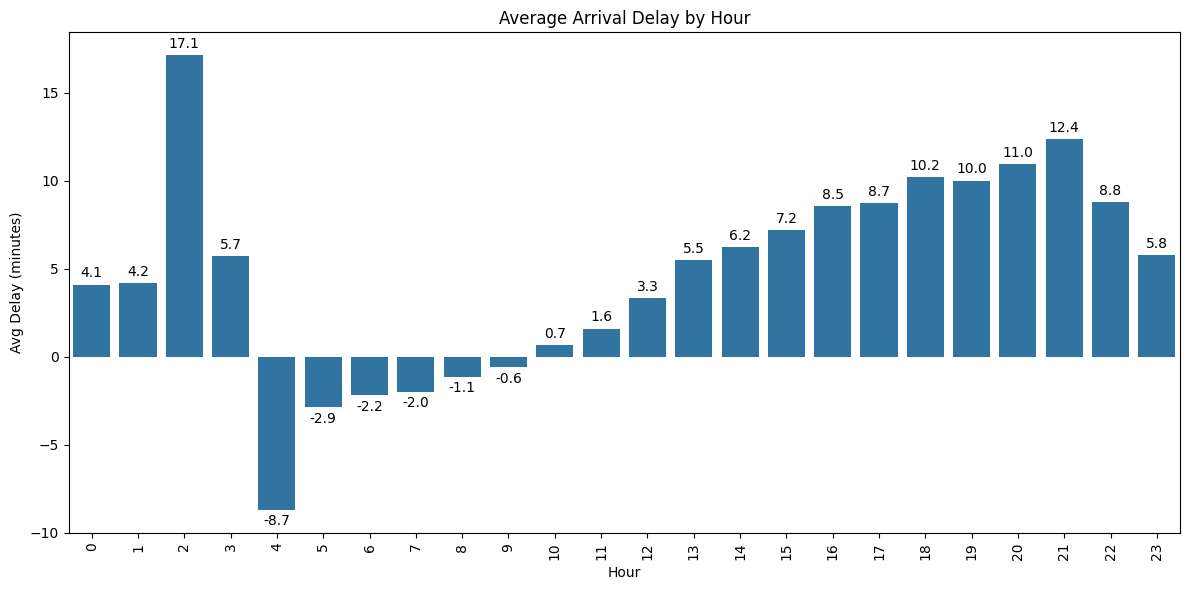

In [66]:
# Average Arrival Delay by Hour
hour_delays = (
    df_pd
      .groupby("DEP_HOUR")["ARR_DELAY"]
      .mean()
      .reset_index()
)

hour_delays = hour_delays.sort_values("DEP_HOUR")

plt.figure(figsize=(12, 6))
sns.barplot(x="DEP_HOUR", y="ARR_DELAY", data=hour_delays)
plt.xticks(rotation=90)
plt.title("Average Arrival Delay by Hour")
plt.xlabel("Hour")
plt.ylabel("Avg Delay (minutes)")
plt.gca().bar_label(plt.gca().containers[0], fmt="%.1f", padding=3)
plt.tight_layout()
plt.show()


## Number of Flights by:
- 1st Graph: Day of Week
- 2nd Graph: Month
- 3rd Graph: Hour of Day
- 4th Graph: Origin City
- 5th Graph: Destination City
- 6th Graph: Airline
- 7th Graph: Delayed by Cause


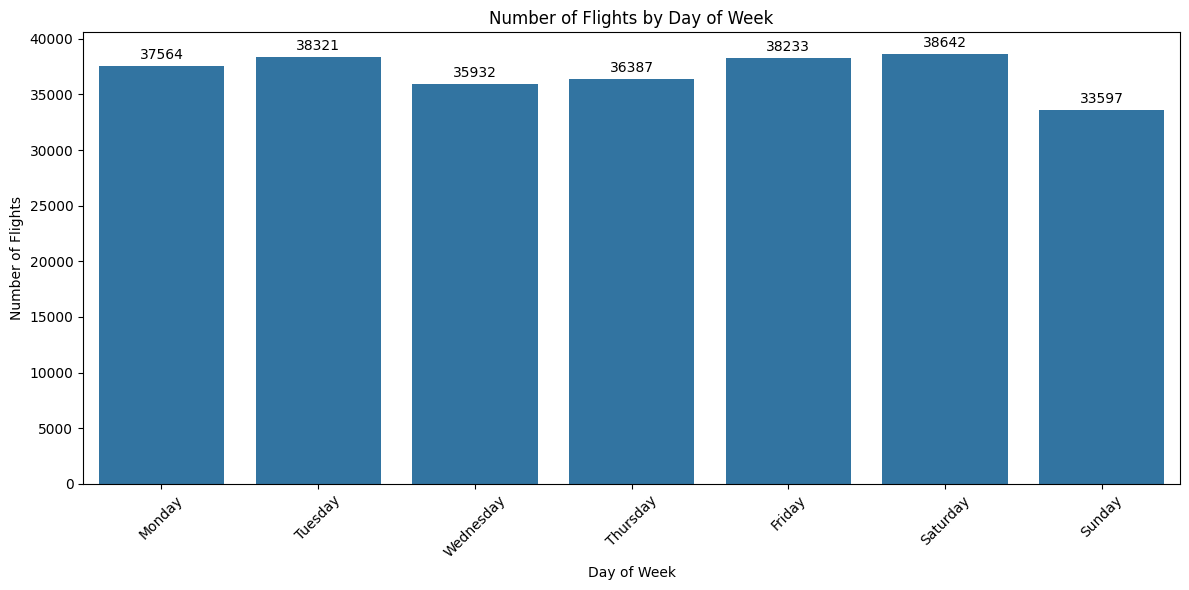

In [67]:
# Number of Flights by Day of Week
day_counts = (
    df_pd
      .groupby("DEP_DAY_OF_WEEK")
      .size()
      .reset_index(name="Number of Flights")
)

# map 1–7 to names and sort
weekday_map = {
    1: "Monday", 2: "Tuesday", 3: "Wednesday",
    4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"
}
day_counts["Weekday"] = day_counts["DEP_DAY_OF_WEEK"].map(weekday_map)
day_counts = day_counts.sort_values("DEP_DAY_OF_WEEK")

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Weekday",
    y="Number of Flights",
    data=day_counts,
    order=list(weekday_map.values()),
    errorbar=None
)
plt.title("Number of Flights by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Flights")

# annotate bars with counts
plt.gca().bar_label(plt.gca().containers[0], fmt="%d", padding=3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

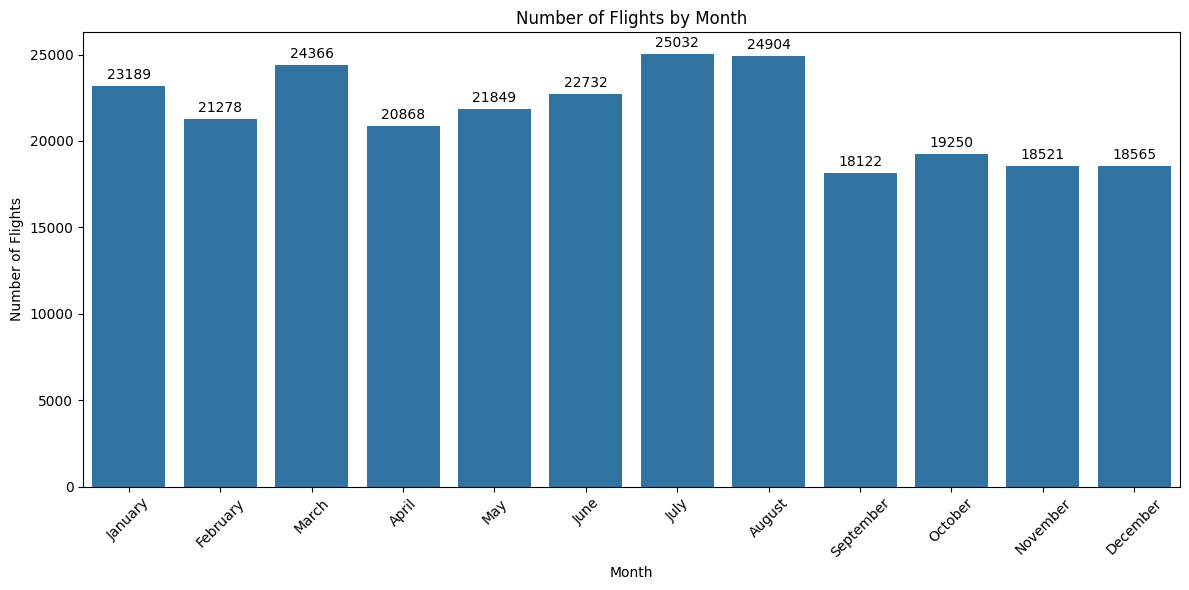

In [68]:
# Number of Flights by Month
monthly_flights = (
    df_pd
      .groupby("DEP_MONTH")
      .size()
      .reset_index(name="Number of Flights")
)

# map 1–12 → month names
month_map = {
    1: "January", 2: "February", 3: "March",    4: "April",
    5: "May",     6: "June",     7: "July",     8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}
monthly_flights["Month"] = monthly_flights["DEP_MONTH"].map(month_map)

# ensure calendar order
order = [month_map[m] for m in range(1, 13)]

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Month",
    y="Number of Flights",
    data=monthly_flights,
    order=order,
    errorbar=None
)
plt.title("Number of Flights by Month")
plt.xlabel("Month")
plt.ylabel("Number of Flights")

# annotate bars with counts
plt.gca().bar_label(plt.gca().containers[0], fmt="%d", padding=3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


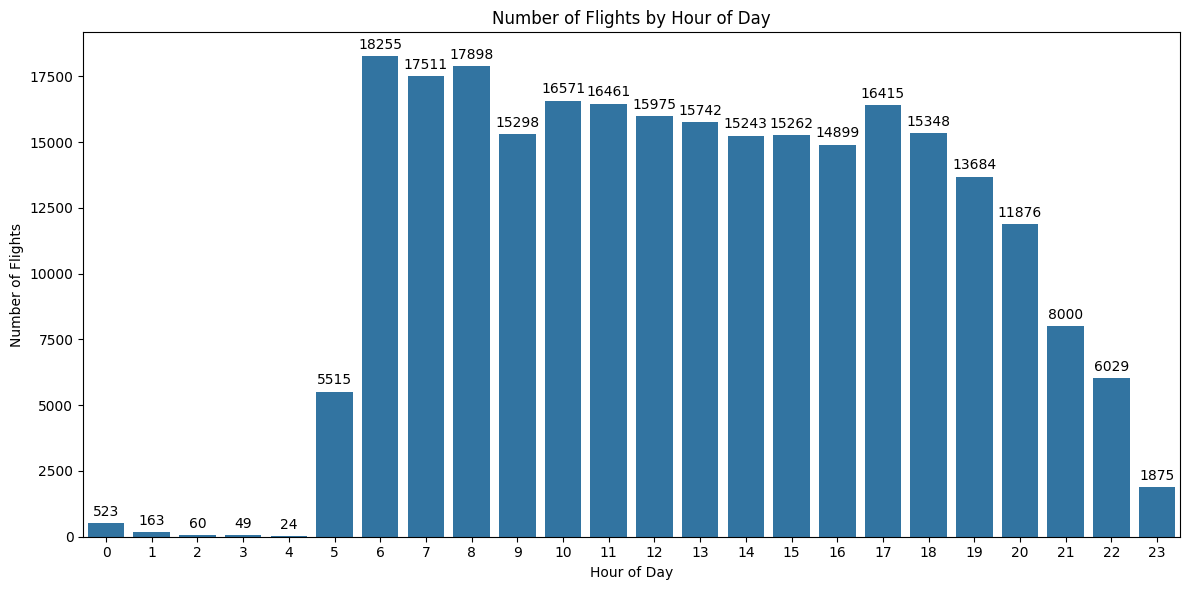

In [69]:
# Number of Flights by Hour of Day
hour_counts = (
    df_pd
      .groupby("DEP_HOUR")
      .size()
      .reset_index(name="Number of Flights")
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x="DEP_HOUR",
    y="Number of Flights",
    data=hour_counts,
    order=sorted(hour_counts["DEP_HOUR"]),
    errorbar=None
)
plt.title("Number of Flights by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Flights")
plt.gca().bar_label(plt.gca().containers[0], fmt="%d", padding=3)
plt.tight_layout()
plt.show()

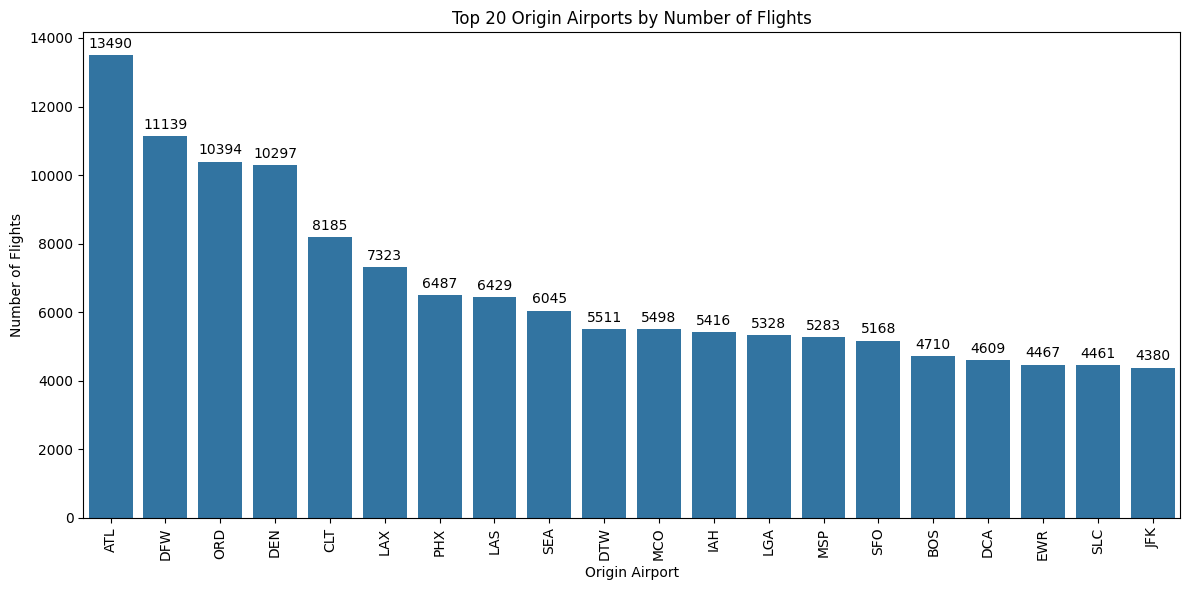

In [70]:
# Number of Flights by Origin City (Top 20)
origin_counts = (
    df_pd
      .groupby("ORIGIN")
      .size()
      .reset_index(name="Number of Flights")
      .sort_values("Number of Flights", ascending=False)
      .head(20)
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x="ORIGIN",
    y="Number of Flights",
    data=origin_counts,
    order=origin_counts["ORIGIN"],
    errorbar=None
)
plt.title("Top 20 Origin Airports by Number of Flights")
plt.xlabel("Origin Airport")
plt.ylabel("Number of Flights")
plt.xticks(rotation=90)
plt.gca().bar_label(plt.gca().containers[0], fmt="%d", padding=3)
plt.tight_layout()
plt.show()

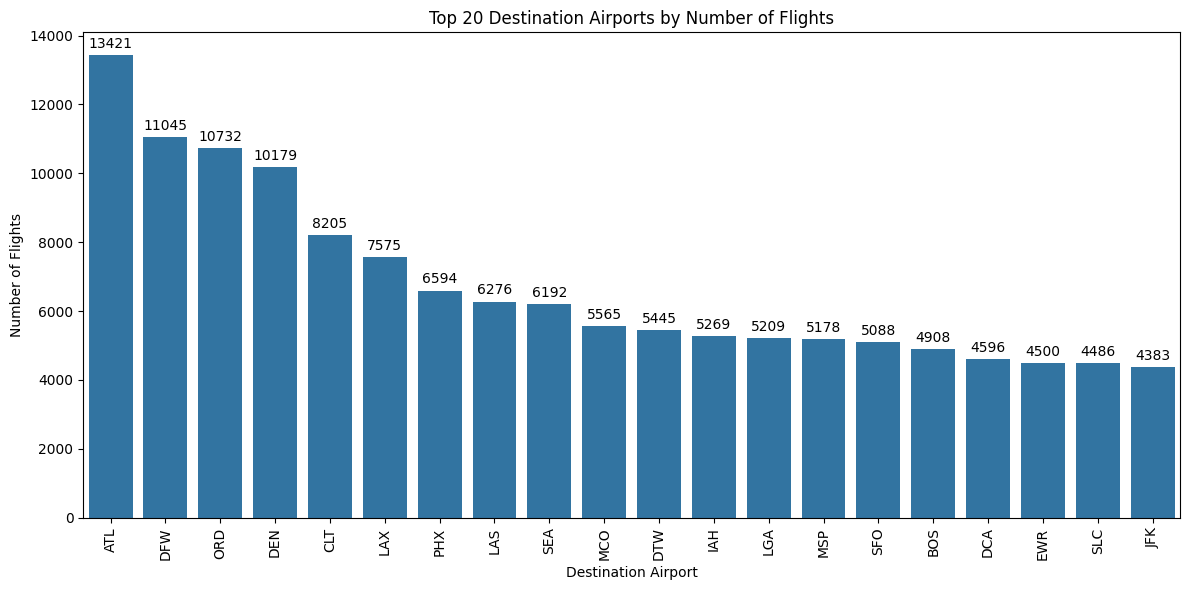

In [71]:
# 5th Graph: Number of Flights by Destination City (Top 20)
dest_counts = (
    df_pd
      .groupby("DEST")
      .size()
      .reset_index(name="Number of Flights")
      .sort_values("Number of Flights", ascending=False)
      .head(20)
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x="DEST",
    y="Number of Flights",
    data=dest_counts,
    order=dest_counts["DEST"],
    errorbar=None
)
plt.title("Top 20 Destination Airports by Number of Flights")
plt.xlabel("Destination Airport")
plt.ylabel("Number of Flights")
plt.xticks(rotation=90)
plt.gca().bar_label(plt.gca().containers[0], fmt="%d", padding=3)
plt.tight_layout()
plt.show()

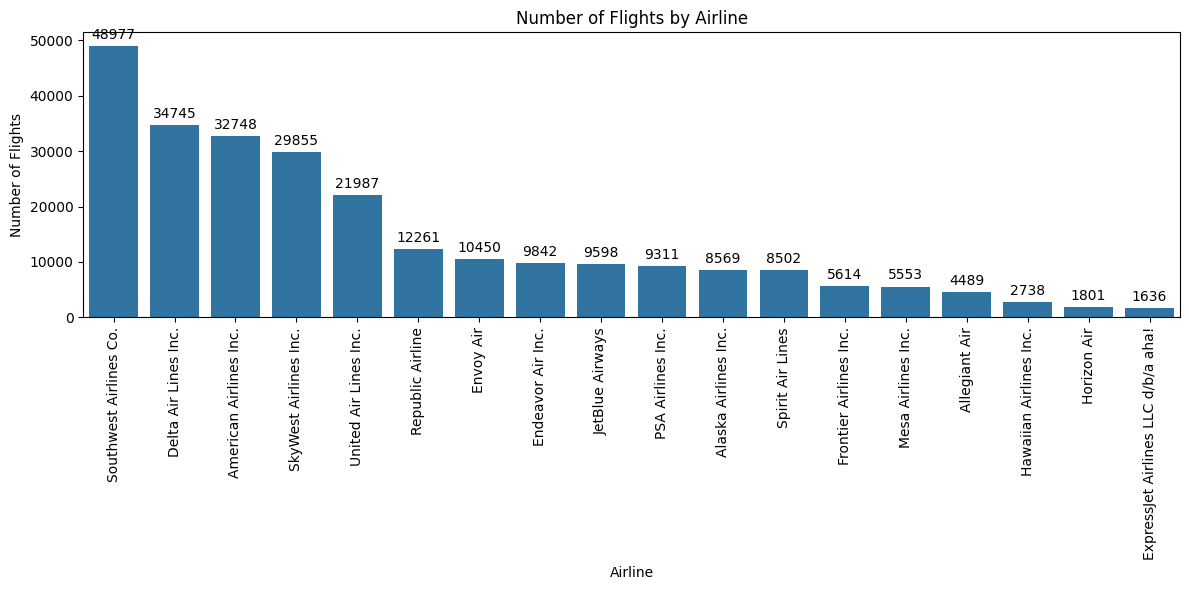

In [72]:
# Number of Flights by Airline
airline_counts = (
    df_pd
      .groupby("AIRLINE")
      .size()
      .reset_index(name="Number of Flights")
      .sort_values("Number of Flights", ascending=False)
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x="AIRLINE",
    y="Number of Flights",
    data=airline_counts,
    order=airline_counts["AIRLINE"],
    errorbar=None
)
plt.title("Number of Flights by Airline")
plt.xlabel("Airline")
plt.ylabel("Number of Flights")
plt.xticks(rotation=90)
plt.gca().bar_label(plt.gca().containers[0], fmt="%d", padding=3)
plt.tight_layout()
plt.show()

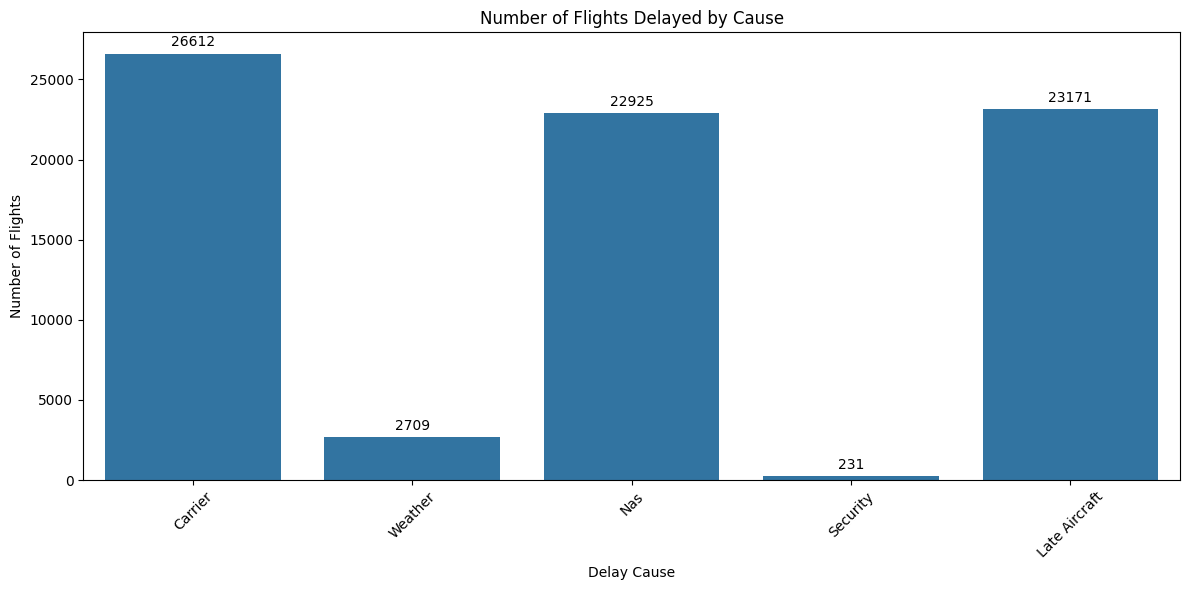

In [73]:
# Number of Flights Delayed by Cause

delay_cols = [
    "DELAY_DUE_CARRIER",
    "DELAY_DUE_WEATHER",
    "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY",
    "DELAY_DUE_LATE_AIRCRAFT"
]

# count how many flights had a delay > 0 for each cause
delay_counts = (
    df_pd[delay_cols]
      .gt(0)
      .sum()
      .reset_index(name="Number of Flights")
)

# clean up column names for plotting
delay_counts.columns = ["Cause", "Number of Flights"]
delay_counts["Cause"] = (
    delay_counts["Cause"]
      .str.replace("DELAY_DUE_", "", regex=False)
      .str.replace("_", " ", regex=False)
      .str.title()
)

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Cause",
    y="Number of Flights",
    data=delay_counts,
    order=delay_counts["Cause"],
    errorbar=None
)
plt.title("Number of Flights Delayed by Cause")
plt.xlabel("Delay Cause")
plt.ylabel("Number of Flights")
plt.xticks(rotation=45)

# annotate bars with counts
plt.gca().bar_label(plt.gca().containers[0], fmt="%d", padding=3)

plt.tight_layout()
plt.show()


## Number of Severe Delays by:
- 1st Graph: Day of Week
- 2nd Graph: Month
- 3rd Graph: Hour of Day
- 4th Graph: Origin City
- 5th Graph: Destination City
- 6th Graph: Airline
- 7th Graph: Delayed by Cause


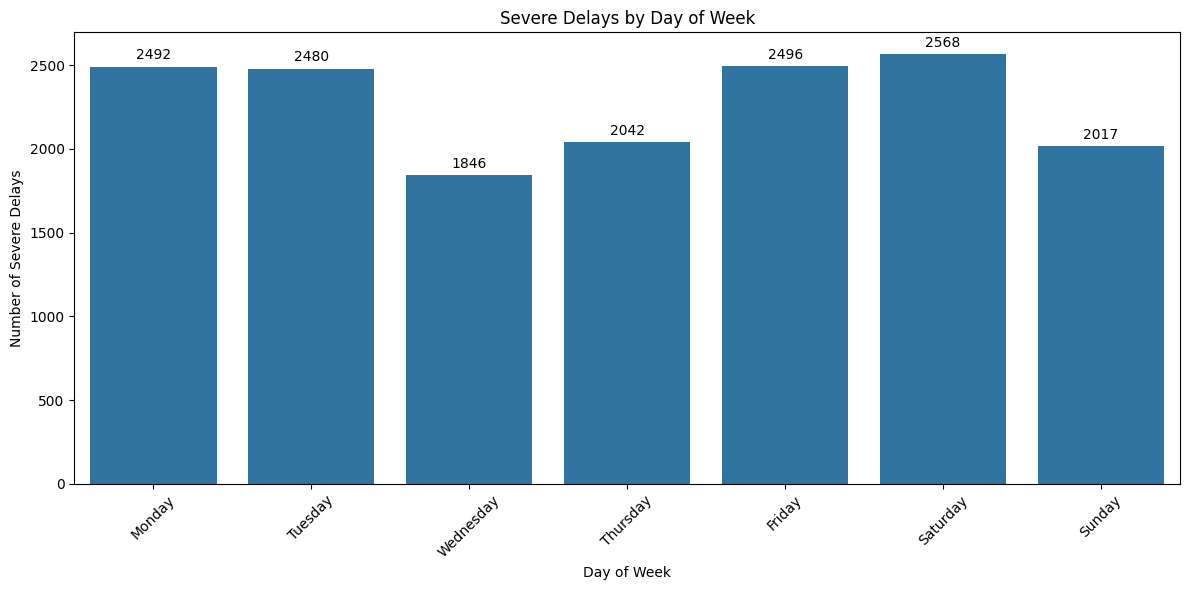

In [76]:
# filter for severe delays
severe = df_pd[df_pd["SEVERE_DELAY"] == 1]

# Number of Severe Delays by Day of Week
day_counts = (
    severe
      .groupby("DEP_DAY_OF_WEEK")
      .size()
      .reset_index(name="Severe Delays")
)
weekday_map = {
    1: "Monday", 2: "Tuesday", 3: "Wednesday",
    4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"
}
day_counts["Weekday"] = day_counts["DEP_DAY_OF_WEEK"].map(weekday_map)
day_counts = day_counts.sort_values("DEP_DAY_OF_WEEK")

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Weekday", y="Severe Delays",
    data=day_counts,
    order=list(weekday_map.values()),
    errorbar=None
)
plt.title("Severe Delays by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Severe Delays")
plt.gca().bar_label(plt.gca().containers[0], fmt="%d", padding=3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

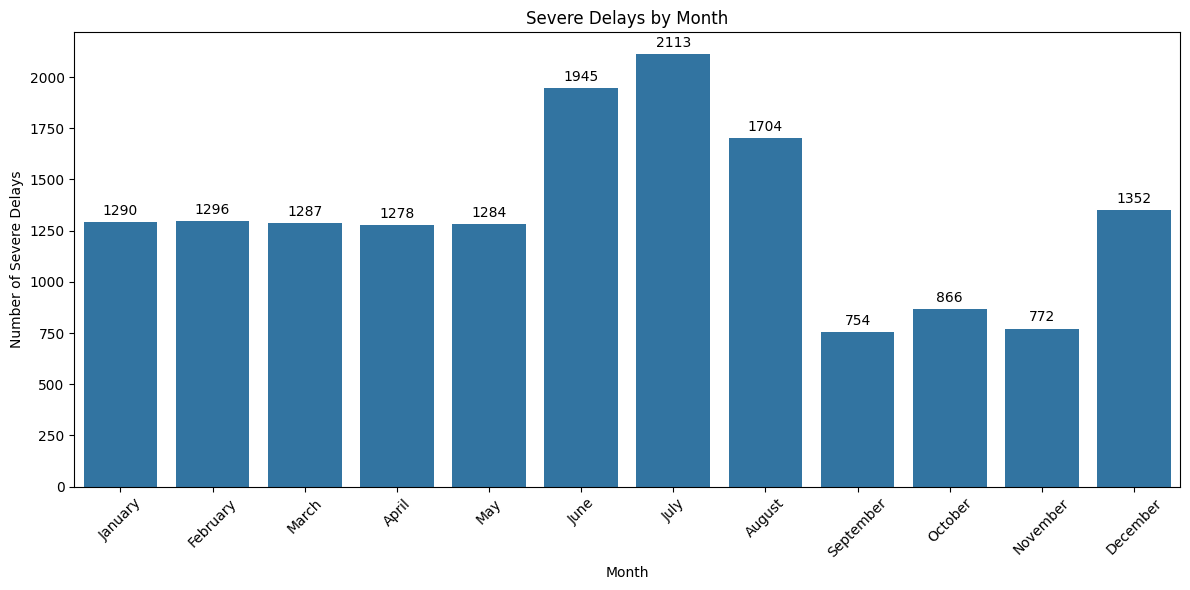

In [78]:
# Number of Severe Delays by Month
month_counts = (
    severe
      .groupby("DEP_MONTH")
      .size()
      .reset_index(name="Severe Delays")
)
month_map = {
    1: "January", 2: "February", 3: "March",    4: "April",
    5: "May",     6: "June",     7: "July",     8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}
month_counts["Month"] = month_counts["DEP_MONTH"].map(month_map)
order = [month_map[m] for m in range(1, 13)]

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Month", y="Severe Delays",
    data=month_counts,
    order=order,
    errorbar=None
)
plt.title("Severe Delays by Month")
plt.xlabel("Month")
plt.ylabel("Number of Severe Delays")
plt.gca().bar_label(plt.gca().containers[0], fmt="%d", padding=3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

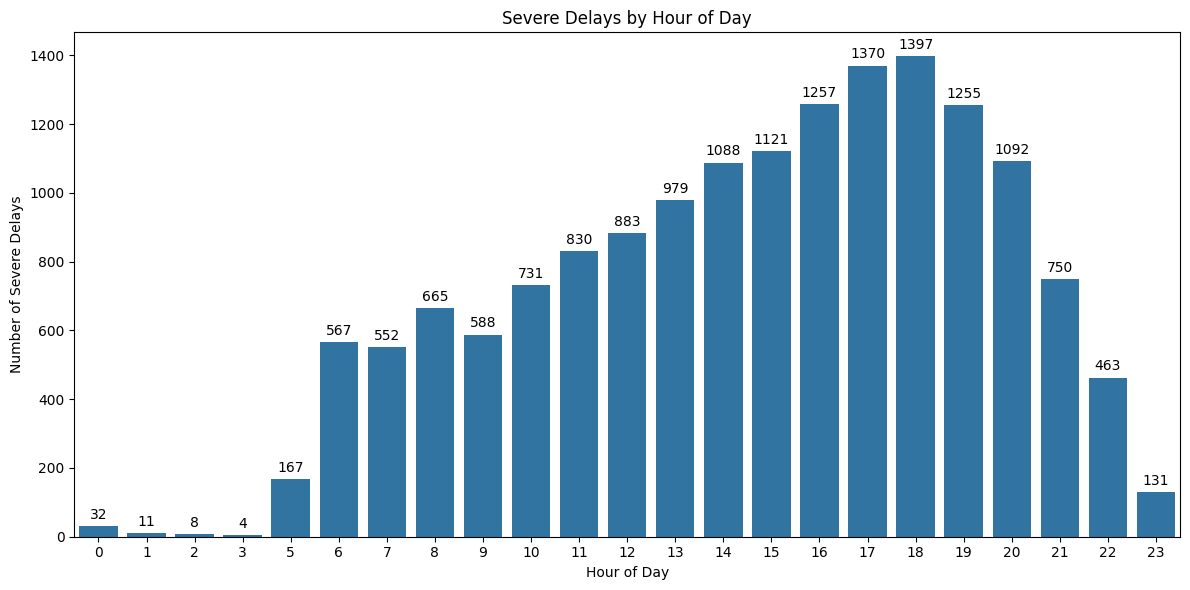

In [80]:
# Number of Severe Delays by Hour of Day
hour_counts = (
    severe
      .groupby("DEP_HOUR")
      .size()
      .reset_index(name="Severe Delays")
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x="DEP_HOUR", y="Severe Delays",
    data=hour_counts,
    order=sorted(hour_counts["DEP_HOUR"]),
    errorbar=None
)
plt.title("Severe Delays by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Severe Delays")
plt.gca().bar_label(plt.gca().containers[0], fmt="%d", padding=3)
plt.tight_layout()
plt.show()


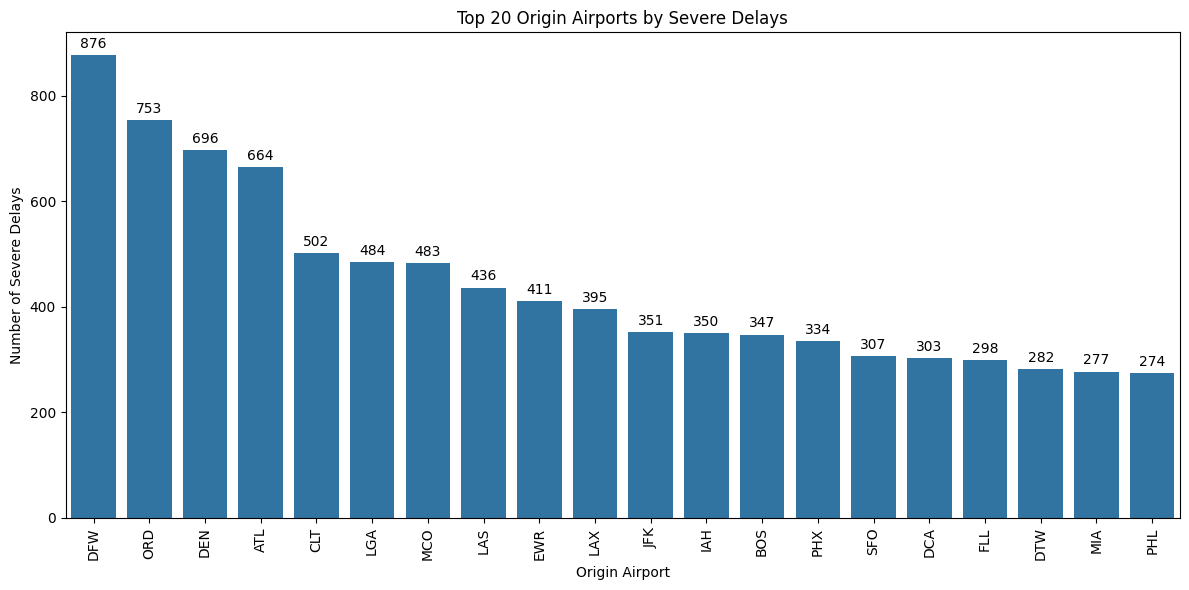

In [82]:
# Number of Severe Delays by Origin City (Top 20)
origin_counts = (
    severe
      .groupby("ORIGIN")
      .size()
      .reset_index(name="Severe Delays")
      .sort_values("Severe Delays", ascending=False)
      .head(20)
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x="ORIGIN", y="Severe Delays",
    data=origin_counts,
    order=origin_counts["ORIGIN"],
    errorbar=None
)
plt.title("Top 20 Origin Airports by Severe Delays")
plt.xlabel("Origin Airport")
plt.ylabel("Number of Severe Delays")
plt.xticks(rotation=90)
plt.gca().bar_label(plt.gca().containers[0], fmt="%d", padding=3)
plt.tight_layout()
plt.show()

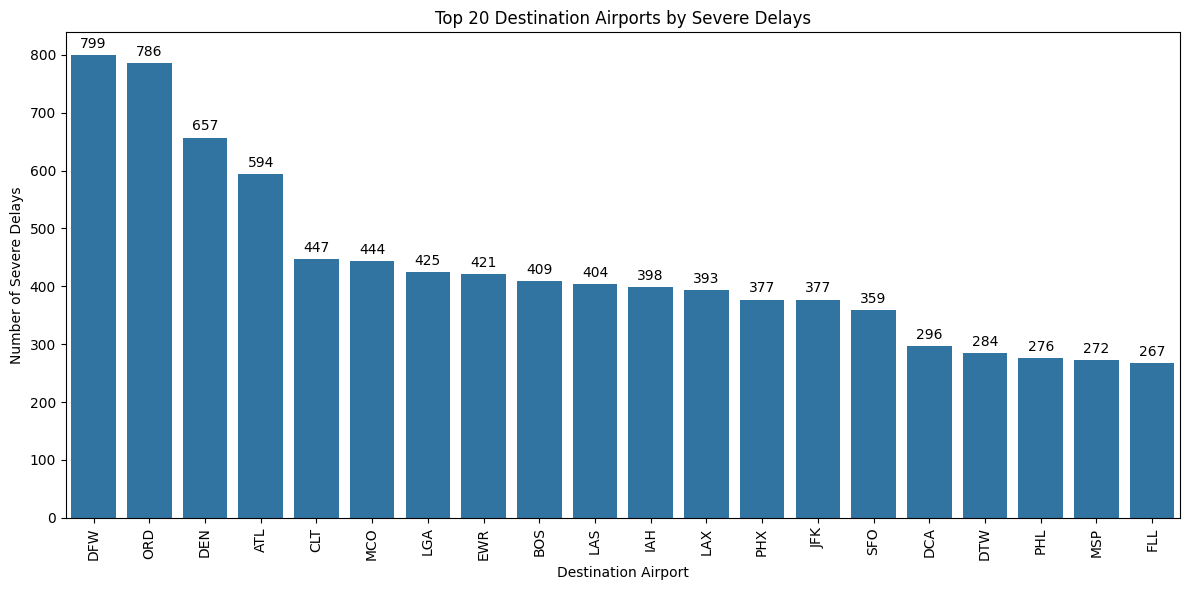

In [84]:
# Number of Severe Delays by Destination City (Top 20)
dest_counts = (
    severe
      .groupby("DEST")
      .size()
      .reset_index(name="Severe Delays")
      .sort_values("Severe Delays", ascending=False)
      .head(20)
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x="DEST", y="Severe Delays",
    data=dest_counts,
    order=dest_counts["DEST"],
    errorbar=None
)
plt.title("Top 20 Destination Airports by Severe Delays")
plt.xlabel("Destination Airport")
plt.ylabel("Number of Severe Delays")
plt.xticks(rotation=90)
plt.gca().bar_label(plt.gca().containers[0], fmt="%d", padding=3)
plt.tight_layout()
plt.show()

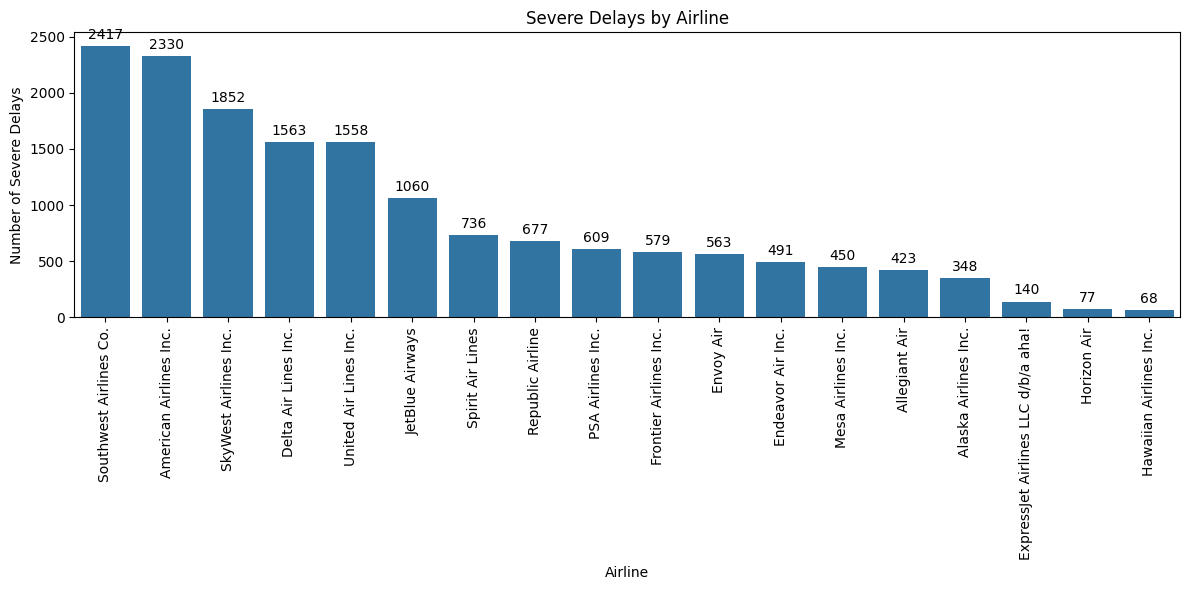

In [86]:
# Number of Severe Delays by Airline
airline_counts = (
    severe
      .groupby("AIRLINE")
      .size()
      .reset_index(name="Severe Delays")
      .sort_values("Severe Delays", ascending=False)
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x="AIRLINE", y="Severe Delays",
    data=airline_counts,
    order=airline_counts["AIRLINE"],
    errorbar=None
)
plt.title("Severe Delays by Airline")
plt.xlabel("Airline")
plt.ylabel("Number of Severe Delays")
plt.xticks(rotation=90)
plt.gca().bar_label(plt.gca().containers[0], fmt="%d", padding=3)
plt.tight_layout()
plt.show()

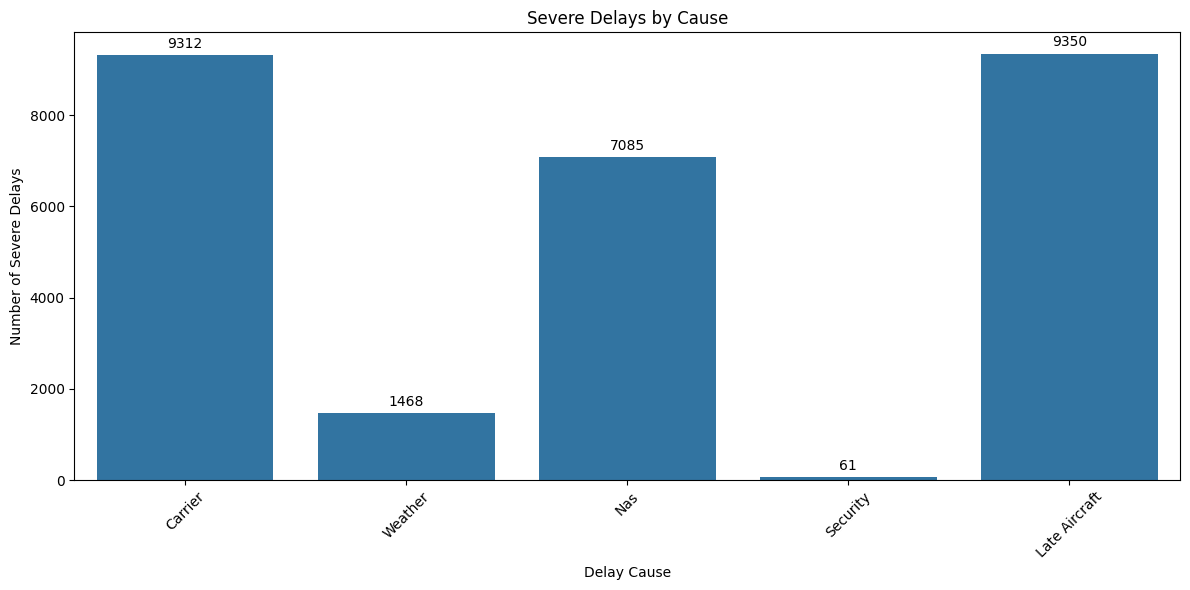

In [88]:
# Number of Severe Delays by Cause
cause_cols = [
    "DELAY_DUE_CARRIER",
    "DELAY_DUE_WEATHER",
    "DELAY_DUE_NAS",
    "DELAY_DUE_SECURITY",
    "DELAY_DUE_LATE_AIRCRAFT"
]
cause_counts = (
    severe[cause_cols]
      .gt(0)
      .sum()
      .reset_index(name="Severe Delays")
)
cause_counts.columns = ["Cause", "Severe Delays"]
cause_counts["Cause"] = (
    cause_counts["Cause"]
      .str.replace("DELAY_DUE_", "", regex=False)
      .str.replace("_", " ", regex=False)
      .str.title()
)

plt.figure(figsize=(12, 6))
sns.barplot(
    x="Cause", y="Severe Delays",
    data=cause_counts,
    order=cause_counts["Cause"],
    errorbar=None
)
plt.title("Severe Delays by Cause")
plt.xlabel("Delay Cause")
plt.ylabel("Number of Severe Delays")
plt.xticks(rotation=45)
plt.gca().bar_label(plt.gca().containers[0], fmt="%d", padding=3)
plt.tight_layout()
plt.show()

## Proportion of Delays & Severe Delays by:
- 1st Graph: Day of Week
- 2nd Graph: Month
- 3rd Graph: Hour of Day
- 4th Graph: Origin City
- 5th Graph: Destination City
- 6th Graph: Airline
- 7th Graph: Delayed by Cause


## TO DO Features:
- How late compared to how long the flight is: Ratio
- efficiency of flights (distance/air_time): Ratio
